### Titanic Survival Prediction :-

The Titanic disaster is a poignant historical event, and analyzing the factors that contributed to survival can provide valuable insights into human behavior in emergencies. This project aims to build a predictive model to determine whether a passenger on the Titanic survived or not based on various features available in the dataset.

In [1]:
###---------------------------
### Import necessary libraries
###---------------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

In [2]:
###-------------
### Load dataset
###-------------

data = pd.read_csv("Titanic-Dataset.csv")

In [3]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
data.shape

(891, 12)

In [5]:
data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Data Preprocessing..

In [7]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

##### Here we will impute value of age by median mode and Embark with most common value and drop the cabin column because it is having  almost 70%+ Missing value 

In [8]:
# Fill missing 'Age' with median value
age_imputer = SimpleImputer(strategy='median')
data['Age'] = age_imputer.fit_transform(data[['Age']])

In [9]:
# Drop the 'Cabin' column due to high number of missing values
data.drop('Cabin', axis=1, inplace=True)

In [10]:
# Fill missing 'Embarked' with the most common value
data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

##### Convert "sex" and "Embarked" into numerical categorical

In [11]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

data = pd.get_dummies(data, columns=['Embarked'], drop_first=True)

##### Verify changes

In [12]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked_Q     0
Embarked_S     0
dtype: int64

In [13]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked_Q,Embarked_S
0,1,0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,A/5 21171,7.2500,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,PC 17599,71.2833,False,False
2,3,1,3,"Heikkinen, Miss. Laina",1,26.0,0,0,STON/O2. 3101282,7.9250,False,True
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,113803,53.1000,False,True
4,5,0,3,"Allen, Mr. William Henry",0,35.0,0,0,373450,8.0500,False,True


### Feature Engineering...

In [14]:
# Create FamilySize feature
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1

In [15]:
# Create IsAlone feature
data['IsAlone'] = (data['FamilySize'] == 1).astype(int)

In [16]:
# Drop columns that are not required
data.drop(['Name', 'Ticket', 'SibSp', 'Parch', 'PassengerId'], axis=1, inplace=True)


In [17]:
data.head()

,Survived,Pclass,Sex,Age,Fare,Embarked_Q,Embarked_S,FamilySize,IsAlone
0,0,3,0,22.0,7.2500,False,True,2,0
1,1,1,1,38.0,71.2833,False,False,2,0
2,1,3,1,26.0,7.9250,False,True,1,1
3,1,1,1,35.0,53.1000,False,True,2,0
4,0,3,0,35.0,8.0500,False,True,1,1


In [18]:
# Checking for imbalanced dataset

data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

### Some visual representation to understand the data in better way..

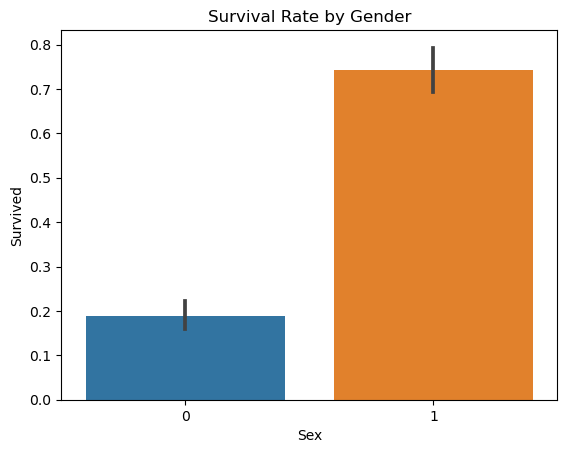

In [19]:
# survival rate by gender
sns.barplot(x='Sex', y='Survived', data=data)
plt.title('Survival Rate by Gender')
plt.show()

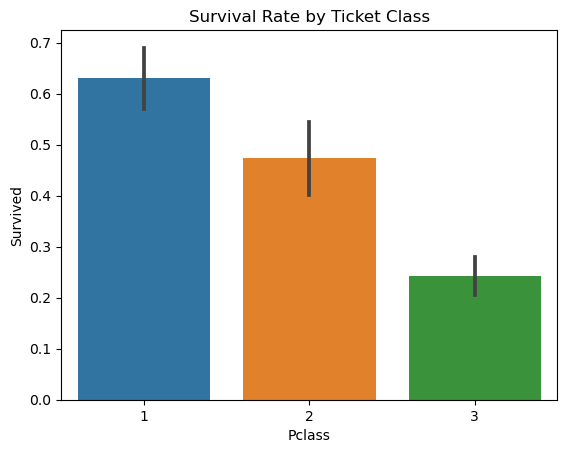

In [20]:
# Survival rate by Pclass
sns.barplot(x='Pclass', y='Survived', data=data)
plt.title('Survival Rate by Ticket Class')
plt.show()

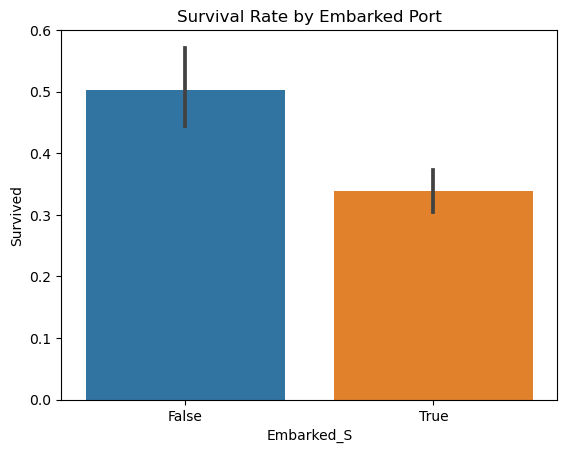

In [21]:
# Survival rate by Embarked
sns.barplot(x='Embarked_S', y='Survived', data=data)
plt.title('Survival Rate by Embarked Port')
plt.show()

### Model Selection..

In [22]:
# Define X and y 

X = data.drop('Survived', axis=1)

y = data['Survived']

In [23]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [24]:
# Initialize baseline models

log_reg = LogisticRegression(max_iter=200, class_weight='balanced')

knn = KNeighborsClassifier()

rf = RandomForestClassifier(class_weight='balanced')


In [25]:
# Function to evaluate models

def evaluate_model(model, X_train, y_train, X_test, y_test):
    
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    
    print(f'{model.__class__.__name__} Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    
    print(classification_report(y_test, y_pred))


In [26]:
# Evaluate baseline models

evaluate_model(log_reg, X_train, y_train, X_test, y_test)

LogisticRegression Accuracy: 0.81
              precision    recall  f1-score   support

           0       0.88      0.80      0.84       110
           1       0.72      0.83      0.77        69

    accuracy                           0.81       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.82      0.81      0.81       179



In [27]:
evaluate_model(knn, X_train, y_train, X_test, y_test)

KNeighborsClassifier Accuracy: 0.74
              precision    recall  f1-score   support

           0       0.76      0.85      0.80       110
           1       0.71      0.57      0.63        69

    accuracy                           0.74       179
   macro avg       0.73      0.71      0.72       179
weighted avg       0.74      0.74      0.74       179



In [28]:
evaluate_model(rf, X_train, y_train, X_test, y_test)

RandomForestClassifier Accuracy: 0.84
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       110
           1       0.82      0.77      0.79        69

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179



In [29]:
# Evaluate RandomForest model with Cross-Validation
cv_scores = cross_val_score(rf, X, y, cv=5)
print(f'RandomForest CV Accuracy: {cv_scores.mean():.2f}')

RandomForest CV Accuracy: 0.80


In [30]:
# Hyperparameter tuning for RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(rf, param_grid, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Print best parameters and best accuracy score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", grid_search.best_score_)

Best Parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}
Best Cross-Validation Accuracy: 0.8244361272530287


In [31]:
# Train model with best parameters
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Confusion Matrix and Classification Report
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))



Confusion Matrix:
 [[99 11]
 [13 56]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89       110
           1       0.84      0.81      0.82        69

    accuracy                           0.87       179
   macro avg       0.86      0.86      0.86       179
weighted avg       0.87      0.87      0.87       179



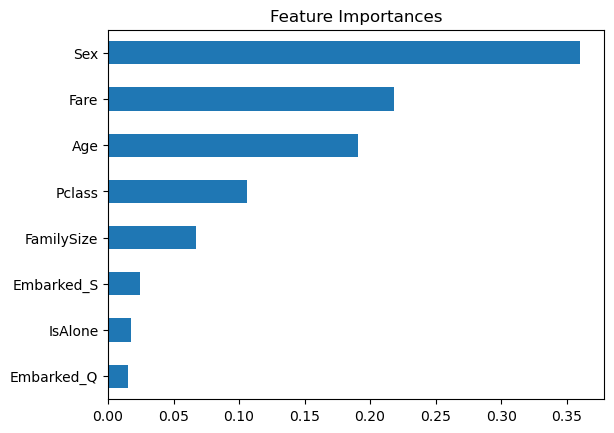

In [32]:
# Feature Importance for Random Forest
importances = pd.Series(best_rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importances')
plt.show()